<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/05_pytorch_going_modular_exercise_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. PyTorch Going Modular Exercises

Welcome to the 05. PyTorch Going Modular exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ijgFhMK3pp4).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/05_pytorch_going_modular_exercise_solutions.ipynb).

## 1. Turn the code to get the data (from section 1. Get Data) into a Python script, such as `get_data.py`.

* When you run the script using `python get_data.py` it should check if the data already exists and skip downloading if it does.
* If the data download is successful, you should be able to access the `pizza_steak_sushi` images from the `data` directory.

In [2]:
import os
from pathlib import Path
import requests
import zipfile

data_path=Path("data")
image_path=data_path/"pizza_steak_sushi"

image_path.mkdir(parents=True, exist_ok=True)

with open (data_path/"pizza_steak_sushi.zip","wb") as f:
    requete=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(requete.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as f:
    f.extractall(image_path)


os.remove(data_path / "pizza_steak_sushi.zip")
     

In [6]:
# Example running of get_data.py
%run get_data.py

data\pizza_steak_sushi directory exists.
Unzipping pizza, steak, sushi data...


## 2. Use [Python's `argparse` module](https://docs.python.org/3/library/argparse.html) to be able to send the `train.py` custom hyperparameter values for training procedures.
* Add an argument flag for using a different:
  * Training/testing directory
  * Learning rate
  * Batch size
  * Number of epochs to train for
  * Number of hidden units in the TinyVGG model
    * Keep the default values for each of the above arguments as what they already are (as in notebook 05).
* For example, you should be able to run something similar to the following line to train a TinyVGG model with a learning rate of 0.003 and a batch size of 64 for 20 epochs: `python train.py --learning_rate 0.003 batch_size 64 num_epochs 20`.
* **Note:** Since `train.py` leverages the other scripts we created in section 05, such as, `model_builder.py`, `utils.py` and `engine.py`, you'll have to make sure they're available to use too. You can find these in the [`going_modular` folder on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular/going_modular). 

## Data Loader ##

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def data_loader(train_path,test_path,transformer,batch,workers):

    train_set = datasets.ImageFolder(root=train_path,
                                     transform=transformer)
    
    test_set = datasets.ImageFolder(root=test_path,
                                     transform=transformer)
    
    data_classes=train_set.classes
    

    train_dl=DataLoader(dataset=train_set,
                        shuffle=True,
                        batch_size=batch,
                        num_workers=workers,
                        pin_memory=True)
    
    test_dl=DataLoader(dataset=test_set,
                        batch_size=batch,
                        num_workers=workers,
                        pin_memory=True)
    
    return data_classes, train_dl, test_dl

## Train/Test step ##

In [4]:
from tqdm.auto import tqdm
from torch import nn

def train_step(train_dl, optimizer, loss_fn, model, device):

    model.train()
    train_loss, train_acc = 0,0 

    for batch, (x,y) in enumerate(train_dl):
        x = x.to(device)
        y = y.to(device)

        y_pred= model(x)

        loss = loss_fn(y_pred,y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(train_dl)
    train_acc = train_acc / len(train_dl)

    return train_loss, train_acc


def test_step(test_dl,loss_fn,model,device):
    model.eval()
    test_loss, test_acc = 0,0
    with torch.inference_mode():
        for batch, (x,y) in enumerate(test_dl):
            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss=loss_fn(y_pred,y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    test_loss =  test_loss / len(test_dl)
    test_acc = test_acc / len(test_dl)

    return test_loss, test_acc
    

C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Iteration entrainement ##

In [5]:
def iteration(train_dl,test_dl,model,optimizer,loss_fn,device,epochs):

    res = {"train_loss": [],
           "test_loss": [],
           "train_acc": [],
           "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           optimizer=optimizer,
                                           loss_fn=loss_fn,
                                           device=device,
                                           train_dl=train_dl)
        

        test_loss, test_acc = test_step(test_dl = test_dl, loss_fn= loss_fn, model=model, device=device)

        res["train_loss"].append(train_loss)
        res["test_loss"].append(test_loss)
        res["train_acc"].append(train_acc)
        res["test_acc"].append(test_acc)

    return res

## Création du modèle ##

In [19]:
class model(nn.Module):
    def __init__(self, input,hidden,output):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input,out_channels=hidden,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*4*4,
                      out_features=output)
        )

    def forward(self,x):
        x = self.classifier(self.block4(self.block3(self.block2(self.block1(x)))))
        return x

## Sauvegarde du modèle ##

In [7]:
def save_model(model:nn.Module,target_dir,nom:str):

    target_dir=Path(target_dir)
    target_dir.mkdir(parents=True, exist_ok=True)

    if nom.endswith('.pth') or nom.endswith('.pt'):
        model_save_path= target_dir / nom
        torch.save(obj=model.state_dict(),f=model_save_path)

In [23]:
train_path = image_path/"train"
test_path = image_path/"test"

data_transformer= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandAugment(),
    transforms.ToTensor()
])

device= "cuda" if torch.cuda.is_available() else "cpu"


data_classes, train_dl, test_dl = data_loader(train_path=train_path,
                                test_path=test_path,
                                transformer=data_transformer,
                                batch=32,
                                workers=os.cpu_count())





model_sila = model(input=3,hidden=20,output=len(data_classes)).to(device)

optimizer= torch.optim.Adam(params=model_sila.parameters(), lr=0.001)
loss_fn=nn.CrossEntropyLoss()


resultat_model= iteration(train_dl=train_dl,
                          test_dl=test_dl,
                          model=model_sila,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          device=device,
                          epochs=100)



100%|██████████| 100/100 [29:49<00:00, 17.90s/it]


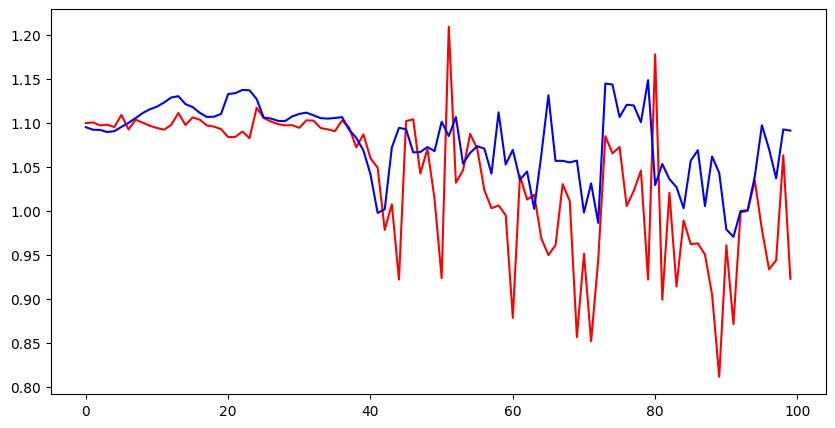

In [24]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.plot(resultat_model["train_loss"],c="red")
plt.plot(resultat_model["test_loss"],c="blue")

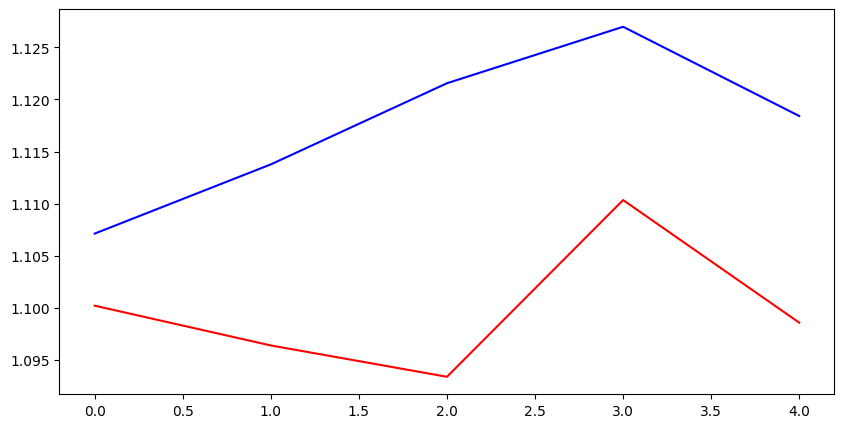

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(resultat_model["train_loss"],c="red")
plt.plot(resultat_model["test_loss"],c="blue")